# AB, $\Pi=0.1$

|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 8/28/2021|

## Introduction

In [1]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
import athena_read
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

### Parameters

In [2]:
units = ['JY07', 'Code']
tlims, epsilons, tau_ss, Ns, Ls, Nps, Pis = [], [], [], [], [], [], []
r = 10                                                 # [H]

athinput = athena_read.athinput('athinput.si')
dt_hst = athinput['output3']['dt']                     # time between hst outputs
Nx = athinput['mesh']['nx1']                           # Radial x zones
Ny = athinput['mesh']['nx3']                           # Azimuthal y zones
Nz = athinput['mesh']['nx2']                           # Vertical z zones
Ns.append(r'${:.0f} \times {:.0f} \times {:.0f}$'.format(Nx, Ny, Nz))
Ns.append(Ns[0])
c_s = athinput['hydro']['iso_sound_speed']             # sound speed
Pi = athinput['problem']['duy0']                       # rad. press. grad.
eta = Pi/r
etav_K = Pi*c_s                                        # velocity (JY07)
Pis.append(eta)
Pis.append(Pi)
Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
Ly = (athinput['mesh']['x3max'] - athinput['mesh']['x3min'])
Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
Ls.append(r'${:.1f} \times {:.1f} \times {:.1f}\,[\eta r]$'.format(Lx/eta/r, Ly/eta/r, Lz/eta/r))
Ls.append(r'${:.1f} \times {:.1f} \times {:.1f}\,[H]$'.format(Lx, Ly, Lz))
Np_tot = athinput['problem']['npx1']\
         *athinput['problem']['npx2']\
         *athinput['problem']['npx3']                  # tot. no. particles
exp = np.log10(Np_tot)
sig = Np_tot/10**int(exp)
Nps.append(r'${:.1f}\times10^{:.0f}$'.format(sig, exp))
Nps.append(r'$n_p={:.0f}$'.format(Np_tot/Nx/Ny/Nz))    # avg. num. part./cell
Omega = athinput['problem']['omega']                   # Keplerian ang. freq.
T = 2*np.pi/Omega                                      # orbital period
tlim = athinput['time']['tlim']
tlims.append(r'${:.1f}\,$'.format(tlim*Omega) + r'$\Omega^{-1}$') # [1/Ω]
tlims.append(r'${:.1f}\,T$'.format(tlim))              # time limit / T
epsilon = athinput['problem']['epsilon']
epsilons.append(epsilon)                               # avg. BG dust/gas ρ
epsilons.append(epsilon)
tau_s = athinput['particles']['taus0']*Omega
tau_ss.append(tau_s)                                   # stopping time
tau_ss.append(tau_s)

df = pd.DataFrame(
    {
        "Units": units,
        r"$\eta,\,\Pi$": Pis,
        r"$\tau_s$": tau_ss,
        r"$\epsilon$": epsilons,
        r"$L_x \times L_y \times L_z$": Ls,
        r"$N_x \times N_y \times N_z$": Ns,
        r"$N_p$": Nps,
        r"$\Delta t$": tlims
    }
)
df.style.format({
    r"$\eta,\,\Pi$": r"${:.3f}$",
    r"$\tau_s$": r"${:.1f}$",
    r"$\epsilon$": r"${:.1f}$",
    r"$\Delta t\,/\,\Omega^{-1}$": r"${:.0f}\,$",
})

,Units,"$\eta,\,\Pi$",$\tau_s$,$\epsilon$,$L_x \times L_y \times L_z$,$N_x \times N_y \times N_z$,$N_p$,$\Delta t$
0,JY07,$0.010$,$0.1$,$1.0$,"$1.0 \times 1.0 \times 1.0\,[\eta r]$",$512 \times 1 \times 512$,$1.0\times10^6$,"$50.3\,$$\Omega^{-1}$"
1,Code,$0.100$,$0.1$,$1.0$,"$0.1 \times 0.1 \times 0.1\,[H]$",$512 \times 1 \times 512$,$n_p=4$,"$8.0\,T$"


### Performance

In [3]:
# Collect HDF5 outputs
outputs = sorted(list(Path('../../athdf').glob(athinput['job']['problem_id'] +
                                            '.out2.*.athdf')))
# Get history output
hst = athena_read.hst('output/SI.hst')

runtime = 9.5956917030000004e+03
hh = runtime//3600
mm = runtime%3600//60
ss = runtime%60

march = ['Skylake']
ncpus = [280]
pes = [256]
cputime = ['%02d:%02d:%02d'%(hh, mm, ss)]
zcs = [1.8970727247425821e+07]
wt = '04:19:45'

df = pd.DataFrame(
    {
        "Microarchitecture": march,
        "CPUs Requested": ncpus,
        "MPI PEs": pes,
        "CPU Time Used": cputime,
        "zone-cycles /cpu_second": zcs,
        "Walltime Used": wt,
    }
)
df.style.format({
    "zone-cycles /cpu_second": "{:.2e}",
})

,Microarchitecture,CPUs Requested,MPI PEs,CPU Time Used,zone-cycles /cpu_second,Walltime Used
0,Skylake,280,256,02:39:55,1.90e+07,04:19:45


## Maximum Particle Density Evolution

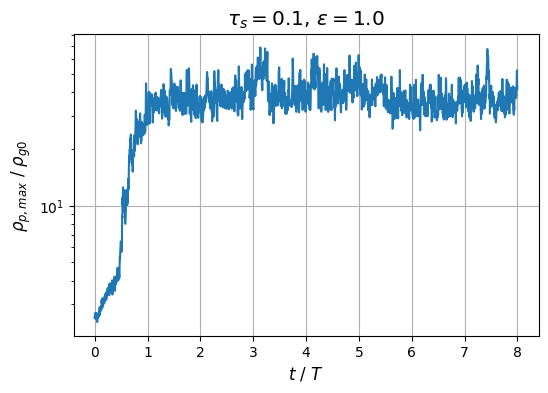

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Load NAS results
data = np.load('output/growth.npz')

# Plot
fig, ax = plt.subplots(dpi=100)
ax.set_title(r'$\tau_s={:.1f},\,\epsilon={:.1f}$'
             .format(tau_s, epsilon), size='x-large')
ax.set_ylabel(r'$\rho_{p,max}$ / $\rho_{g0}$', size='large')
ax.set_xlabel(r'$t$ / $T$', size='large')
ax.semilogy(data['times'], data['rhopmax'])
ax.grid()

**NOTE**: We define $t_\textrm{sat} = \#\,T$ in the calculations and plots below.

In [5]:
t_sat = 1 # T

## Mean Particle Velocities

In [6]:
# Time-averaged velocities over saturated state
i_sat = int(t_sat / dt_hst) # output index of sat. state
avg_vp1s = np.average(hst['vp1'][i_sat:])/etav_K/Np_tot
avg_vp2s = np.average(hst['vp2'][i_sat:])/etav_K/Np_tot
avg_vp3s = np.average(hst['vp3'][i_sat:])/etav_K/Np_tot

df = pd.DataFrame(
    {
        r"$\overline{v_x}$": [avg_vp1s],
        r"$\overline{v_y}$": [avg_vp3s],
        r"$\overline{v_z}$": [avg_vp2s],
    }
)
df.style.format({
    r"$\overline{v_x}$": "{:.3f}",
    "% diff (JY07)": "{:.1f}",
    r"$\overline{v_y}$": "{:.3f}",
    r"$\overline{v_z}$": "{:.3f}",
})

,$\overline{v_x}$,$\overline{v_y}$,$\overline{v_z}$
0,-0.109,-0.484,-0.000


## Cumulative Particle Density Distribution

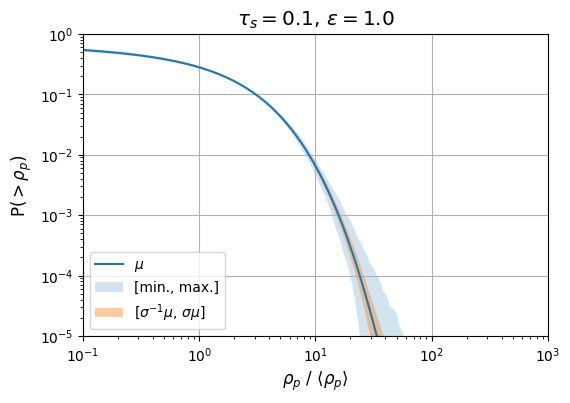

In [7]:
# Load NAS results
data = np.load('output/cpdd.npz')
cdf = data['cdf']
mins = data['mins']
maxs = data['maxs']
avgs = data['avgs']
stds = data['stds']

# CPDD
fig, ax = plt.subplots(dpi=100)
ax.set_title(r'$\tau_s={:.1f},\,\epsilon={:.1f}$'
             .format(tau_s, epsilon), size='x-large')
ax.set_xlabel(r'$\rho_p$ / $\langle \rho_p \rangle$', size='large')
ax.set_ylabel(r'P$(>\rho_p)$', size='large')
ax.loglog(avgs, cdf, label=r'$\mu$')
ax.fill_betweenx(cdf, mins, maxs, alpha=0.2, label='[min., max.]')
ax.fill_betweenx(cdf, avgs/stds, avgs*stds, alpha=0.4,
                 label=r'$[\sigma^{-1}\mu,\,\sigma\mu]$')
ax.set(xlim=(0.1, 1000), ylim=(1e-5, 1))
ax.legend(loc='lower left')
ax.grid()

**NOTE**:
- We compute the statistical values over the time-varying saturated state defined [above](#Maximum-Particle-Density-Evolution).
- We calculate the standard deviation, $\sigma$, in logarithmic space.

## Particle Density Animation

In [8]:
IFrame('https://www.youtube.com/embed/3hKP_vstj1U', 560, 315)

## Tasks

- [x] Configure `athinput.si` with converted JY07 run [parameters](#Parameters)
- [x] Run simulation: `qsub run.pbs`
- [x] Run `growth.py`
- [x] Transfer from NAS, `sup shiftc -r ../output/`:
- [x] Record runtime performance
- [x] Calc mean dust velocities w/ `i_sat`
- [x] `cpdd.py`:
  - [x] Set `t_sat` then run; 
  - [x] Re-transfer `output/`
- [x] Particle density animation:
  - [x] `mov.py`: Set `vmin` and `vmax` from `growth.pdf` then run
  - [x] Transfer `rhop.mp4` from NAS
  - [x] Upload to YouTube
  - [x] Embed in [Particle Density Animation](#Particle-Density-Animation)